# Multinomial Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import math
import wandb
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
data = pd.read_csv("WineQT.csv")
print(data.shape)
feature_names = data.columns.to_list()
# print(feature_names)

(1143, 13)


In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


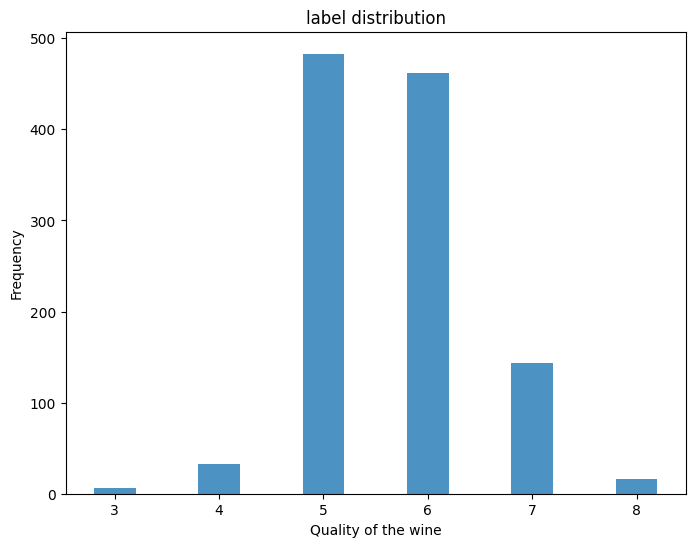

In [4]:
quality_label = data['quality']

unique_label, label_counts = np.unique(quality_label, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_label, label_counts, width=0.4, alpha=0.8)
plt.xlabel('Quality of the wine')
plt.ylabel('Frequency')
plt.title('label distribution')
plt.show()

In [5]:
data_ = data.values
X = data_[:, 0:11]
# print(X.shape)
y = data_[:, 11]
y = y.astype(int)
# print(y)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

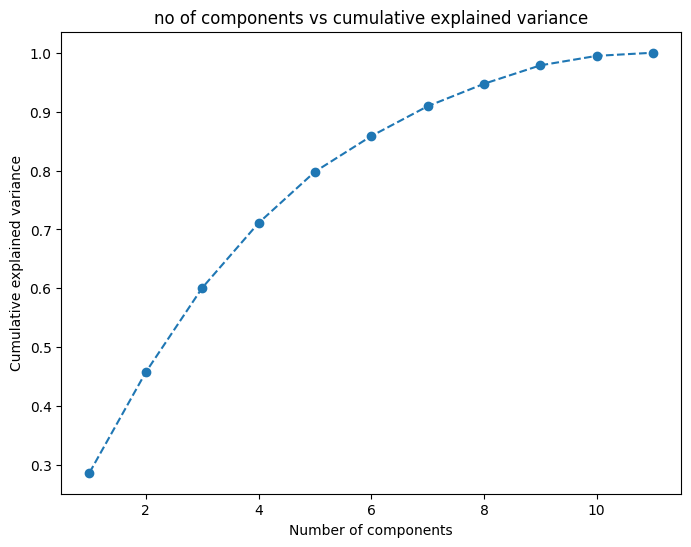

The most significant features:  ['alcohol' 'density']


In [7]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('no of components vs cumulative explained variance')
plt.show()

loadings = pca.components_
# loadings = loadings[:6, :]

feature_weightage = np.abs(loadings).sum(axis=0)
sorted_indices = np.argsort(feature_weightage)[::-1]
# print(feature_weightage)

most_significant_features_indices = sorted_indices[:2]
most_significant_features = np.array(feature_names)[most_significant_features_indices]
print("The most significant features: ", most_significant_features)

In [8]:
# X = X_scaled[:, most_significant_features_indices]

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.67, random_state=42)

In [9]:
class Multinomial_Classification:
    def __init__(self, X, y, X_val, y_val, learning_rate = 0.005, max_epoch = 3000 ):
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch
        self.loss = 0
        self.X = np.column_stack((np.ones((X.shape[0], 1)), X))
        self.y = y
        self.X_val = np.column_stack((np.ones((X_val.shape[0], 1)), X_val))
        self.y_val = y_val
        self.n_samples, self.n_features = self.X.shape
        self.n_classes = 10
        self.weights = np.random.rand(self.n_features, self.n_classes)

    def one_hot_encoding(self, y):    
        y_encoded = np.zeros((len(y), self.n_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded

    def softmax(self, Z):
        y_pred = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        return y_pred
    
    def loss_function(self, y_actual, y_pred):
        loss = -1/self.n_samples * np.sum(y_actual * np.log(y_pred))
        return loss

    def accuracy(self, y_actual, y_pred):
        y_pred = np.argmax(y_pred, axis=1)
        y_actual = np.argmax(y_actual, axis=1)
        accuracy = np.mean(y_pred == y_actual)
        return accuracy

    def loss_derivate_gradient(self, y_actual, y_pred):
        gradient = -1/self.n_samples * np.dot(self.X.T, (y_actual - y_pred))
        return gradient

    def fit(self):
        v_epochs = []
        train_loss = []
        train_accuracy = []
        val_loss = []
        val_accuracy = []
        epochCount =0

        while(epochCount <  self.max_epoch):
            y_actual = self.one_hot_encoding(self.y)
            Z = np.matmul(self.X, self.weights)
            y_pred = self.softmax(Z)
            loss = self.loss_function(y_actual, y_pred)
            accuracy = self.accuracy(y_actual, y_pred)
            gradient = self.loss_derivate_gradient(y_actual, y_pred)
            self.weights = self.weights - self.learning_rate * gradient
            train_loss.append(loss)
            train_accuracy.append(accuracy)

            y_actual_val = self.one_hot_encoding(self.y_val)
            Z = np.matmul(self.X_val, self.weights)
            y_pred_val = self.softmax(Z)
            loss_val = self.loss_function(y_actual_val, y_pred_val) * self.n_samples / self.X_val.shape[0]
            accuracy_val = self.accuracy(y_actual_val, y_pred_val)
            val_loss.append(loss_val)
            val_accuracy.append(accuracy_val)
            
            # if(epochCount% (self.max_epoch/100)==0):
                # print(f'Epoch {epochCount+1}/{self.max_epoch} error: {error:.4f} accuracy: {self.validate(X, y):.4f}')
            epochCount += 1

            
        self.loss = loss
        self.train_loss = train_loss
        self.train_accuracy = train_accuracy
        self.val_loss = val_loss
        self.val_accuracy = val_accuracy
        # self.v_epochs = v_epochs
        # self.show_err_graph(v_epochs, totalError)

    def show_err_graph(self):
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.train_loss)+1), self.train_loss)
        plt.xlabel("Number of Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Number of Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.train_accuracy)+1), self.train_accuracy)
        plt.xlabel("Number of Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Number of Epoch")

    def predict(self, X):
        constant_column = np.ones((X.shape[0], 1))
        X = np.column_stack((constant_column, X))

        Z = np.matmul(X, self.weights)
        y_pred = self.softmax(Z)
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred
    
    def validate(self, X, y):
        n_samples, _ = X.shape
        y_pred = self.predict(X)
        constant_column = np.ones((X.shape[0], 1))
        X = np.column_stack((constant_column, X))
        accuracy = np.mean(y_pred == y)
        self.loss = self.loss_function(n_samples, self.one_hot_encoding(y, self.n_classes), self.softmax(np.matmul(X, self.weights)))

        return accuracy, self.loss

    def get_metric_for_each_epoch(self):
        return self.train_accuracy, self.train_loss, self.val_accuracy, self.val_loss

In [35]:
model = Multinomial_Classification(X_train, y_train, X_val, y_val, learning_rate=0.05, max_epoch=5000)
model.fit()
y_pred = model.predict(X_val)
train_accuracy, train_loss, val_accuracy, val_loss = model.get_metric_for_each_epoch()

for accuracy, loss, epoch_count in zip(train_accuracy, train_loss, range(1, len(train_accuracy)+1)):
    print(f'Epoch {epoch_count} - Accuracy: {accuracy} Loss: {loss}')

Epoch 1 - Accuracy: 0.105 Loss: 2.627220274690609
Epoch 2 - Accuracy: 0.1075 Loss: 2.6017123373590914
Epoch 3 - Accuracy: 0.115 Loss: 2.5765248904619615
Epoch 4 - Accuracy: 0.12 Loss: 2.551658905908906
Epoch 5 - Accuracy: 0.12125 Loss: 2.527115300998348
Epoch 6 - Accuracy: 0.13375 Loss: 2.5028949307611605
Epoch 7 - Accuracy: 0.14125 Loss: 2.4789985800307406
Epoch 8 - Accuracy: 0.14375 Loss: 2.4554269553047714
Epoch 9 - Accuracy: 0.1475 Loss: 2.4321806764710217
Epoch 10 - Accuracy: 0.16125 Loss: 2.4092602684752307
Epoch 11 - Accuracy: 0.17125 Loss: 2.386666153013302
Epoch 12 - Accuracy: 0.17625 Loss: 2.3643986403326607
Epoch 13 - Accuracy: 0.18125 Loss: 2.3424579212286107
Epoch 14 - Accuracy: 0.18625 Loss: 2.3208440593209234
Epoch 15 - Accuracy: 0.19375 Loss: 2.2995569836936864
Epoch 16 - Accuracy: 0.1975 Loss: 2.278596481977767
Epoch 17 - Accuracy: 0.1975 Loss: 2.2579621939502057
Epoch 18 - Accuracy: 0.20875 Loss: 2.2376536057185925
Epoch 19 - Accuracy: 0.22125 Loss: 2.217670044551178


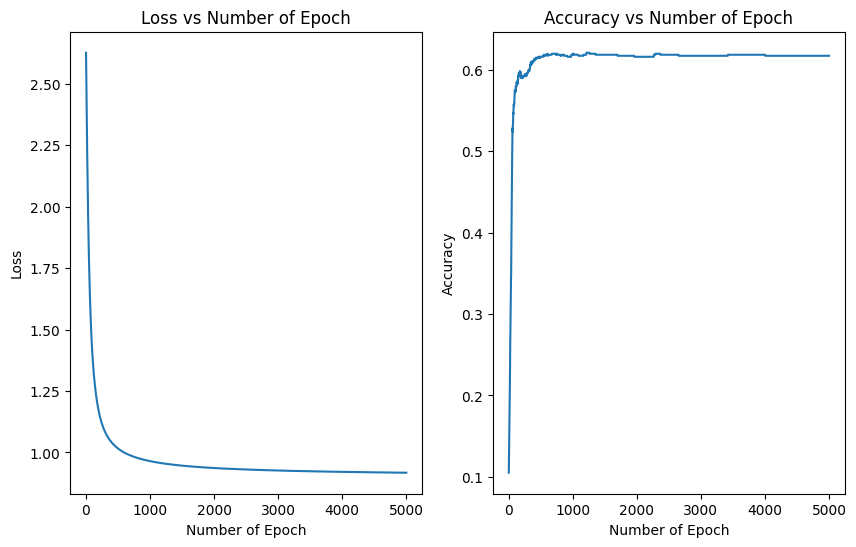

In [36]:
model.show_err_graph()

In [ ]:
classification_metrics = classification_report(y_val, y_pred, zero_division=0)
print(classification_metrics)

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2
           5       0.60      0.74      0.66        42
           6       0.67      0.61      0.64        56
           7       0.50      0.38      0.43        13

    accuracy                           0.62       113
   macro avg       0.44      0.43      0.43       113
weighted avg       0.61      0.62      0.61       113



In [38]:
most_significant_features_indices = [1, 10]
most_significant_features = np.array(feature_names)[most_significant_features_indices]

X_ = X_train[:, most_significant_features_indices]
model = Multinomial_Classification(X_, y_train, X_val[:, most_significant_features_indices], y_val, learning_rate=0.001, max_epoch=100000)
model.fit()
y_pred = model.predict(X_val[:, most_significant_features_indices])

[4 5 6 7]


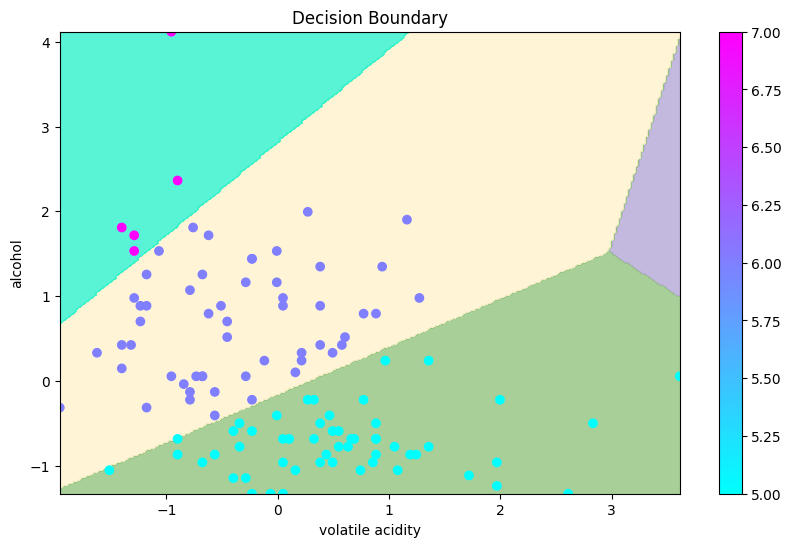

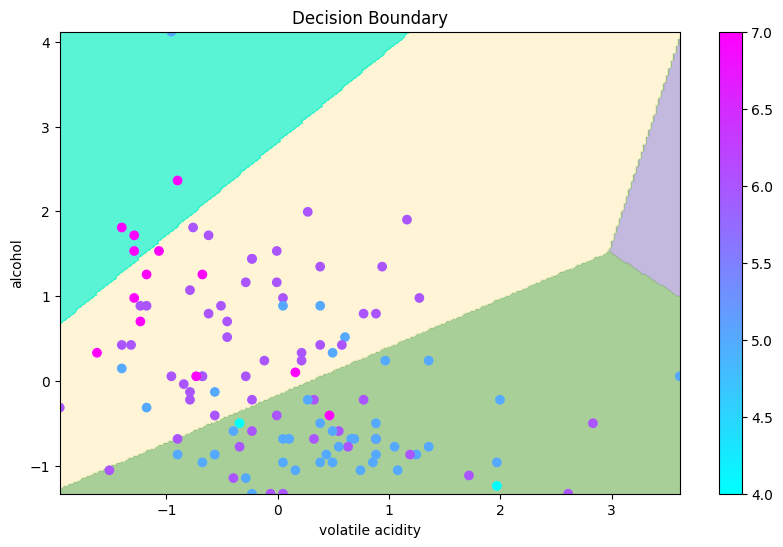

In [40]:
custom_map = ListedColormap(['#b4a7d6','#93c47d','#fff2cc', '#30f2cc'])

feature1 = X_val[:, most_significant_features_indices[0]]
feature2 = X_val[:, most_significant_features_indices[1]]
num_classes = np.max(y) + 1

feature1_range = np.linspace(np.min(feature1), np.max(feature1), 250)
feature2_range = np.linspace(np.min(feature2), np.max(feature2), 250)
# print(feature1_range)

feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)
X_grid = np.column_stack((feature1_grid.ravel(), feature2_grid.ravel()))
y_predict = model.predict(X_grid)
print(np.unique(y_predict))
y_predict = y_predict.reshape(feature1_grid.shape)


plt.figure(figsize=(10, 6))
plt.contourf(feature1_grid, feature2_grid, y_predict, cmap=custom_map, alpha=0.8)
plt.scatter(feature1, feature2, c=y_pred, cmap='cool', marker='o')
plt.xlabel(most_significant_features[0])
plt.ylabel(most_significant_features[1])
plt.title('Decision Boundary')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.contourf(feature1_grid, feature2_grid, y_predict, cmap=custom_map, alpha=0.8)
plt.scatter(feature1, feature2, c=y_val, cmap='cool', marker='o')
plt.xlabel(most_significant_features[0])
plt.ylabel(most_significant_features[1])
plt.title('Decision Boundary')
plt.colorbar()
plt.show()


In [ ]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "epochs": {"values": [10000, 7500, 5000, 1000]},
        "lr": {"values": [0.005, 0.01, 0.025, 0.05, 0.075]},
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="softmax-classification-1")

def tuning():
    run = wandb.init()

    lr = wandb.config.lr
    epochs = wandb.config.epochs

    # for epoch in np.arange(epochs-10, epochs):
    model = Multinomial_Classification(X_train, y_train, X_val, y_val, learning_rate=lr, max_epoch=epochs)
    model.fit()

    train_accuracy, train_loss, val_accuracy, val_loss = model.get_metric_for_each_epoch()
    for accuracy, loss in zip(val_accuracy, val_loss):
        wandb.log({"accuracy": accuracy, "loss": loss})


wandb.agent(sweep_id, function=tuning, count=16)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: yapi2tme
Sweep URL: https://wandb.ai/anushka-agrawal/softmax-classification-1/sweeps/yapi2tme


wandb: Agent Starting Run: 4tj19mhr with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁████████▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95762


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 021trrda with config:
wandb: 	epochs: 1000
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▅▆▇▇██████████████████████████████████
loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,0.97905


wandb: Agent Starting Run: 9o2o3740 with config:
wandb: 	epochs: 7500
wandb: 	lr: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▅▆▇▇▇▇▇█▇▇▇▇▇█████████████████████████
loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.63717
loss,0.99908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rps6iubr with config:
wandb: 	epochs: 7500
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.96052


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1dc1opnc with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.075
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95586


wandb: Agent Starting Run: 0a7qpdan with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▇█▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95839


wandb: Agent Starting Run: 5p95uuel with config:
wandb: 	epochs: 1000
wandb: 	lr: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▂▃▃▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
loss,█▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,1.17048


wandb: Agent Starting Run: 5yv6fz20 with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▆█▇██████████████████████████████████▇
loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.97243


wandb: Agent Starting Run: nkf4pde4 with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.075
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95611


wandb: Agent Starting Run: ixbg24iw with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆█▇█▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95794


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: obyy4i4t with config:
wandb: 	epochs: 7500
wandb: 	lr: 0.075
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆██▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.95739


wandb: Agent Starting Run: 7z9apqnb with config:
wandb: 	epochs: 5000
wandb: 	lr: 0.025
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▇█████▇▇████████████████████▇▇▇▇▇▇▇▇▇▇
loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.96991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: orqo61js with config:
wandb: 	epochs: 1000
wandb: 	lr: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████
loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.64602
loss,1.17059


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kj2l6mju with config:
wandb: 	epochs: 5000
wandb: 	lr: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▃▄▅▆▆▆▆▇▇▇▇███████████████████████████
loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.60177
loss,1.0271


wandb: Agent Starting Run: viyxa8wr with config:
wandb: 	epochs: 10000
wandb: 	lr: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▄▇█████████▇██████████████████████████
loss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.64602
loss,0.98199


wandb: Agent Starting Run: jkw8t086 with config:
wandb: 	epochs: 7500
wandb: 	lr: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇▇█▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.61947
loss,0.96103


The link to my wandb report:
https://api.wandb.ai/links/anushka-agrawal/itxwngim

              precision    recall  f1-score   support

           4       0.00      0.00      1.00         7
           5       0.69      0.74      0.71       101
           6       0.56      0.64      0.60        90
           7       0.62      0.36      0.45        28
           8       1.00      0.00      0.00         4

    accuracy                           0.62       230
   macro avg       0.57      0.35      0.55       230
weighted avg       0.61      0.62      0.63       230



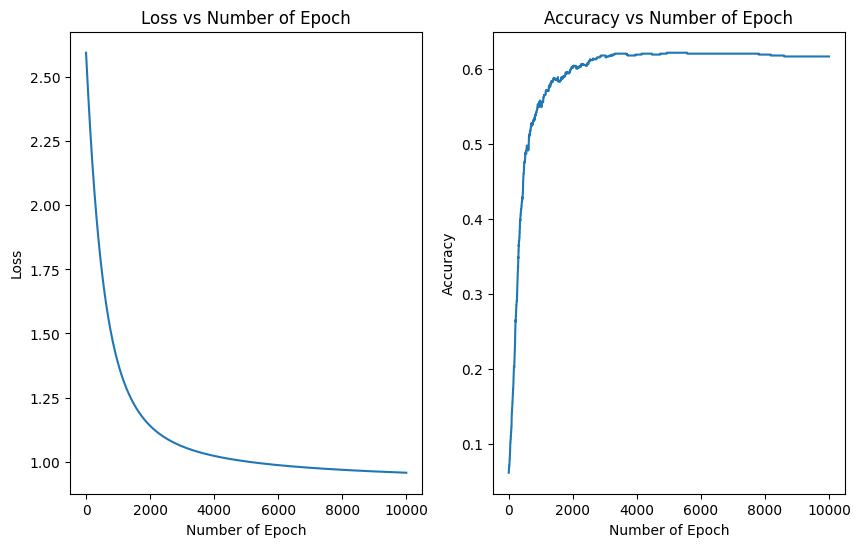

In [10]:
learning_rate = 0.005
max_epochs = 10000

regression_model = Multinomial_Classification(X_train, y_train, X_val, y_val, learning_rate=learning_rate, max_epoch=max_epochs)    
regression_model.fit()
y_pred = regression_model.predict(X_test)
regression_model.show_err_graph()

classification_metrics = classification_report(y_test, y_pred, zero_division=1)
print(classification_metrics)

# Multi layer Perceptron 

In [11]:
# multi-layer perceptron (MLP)
class MLP:
    def __init__(self, X, y, X_val, y_val, activation_func = 'sigmoid', optimizer = 'batch', learning_rate = 0.01, max_epochs = 5000, hidden_layer_neurons = 10, hidden_layers = 1):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = np.zeros((len(y), np.max(y)+1))
        self.y[np.arange(len(y)), y] = 1
        self.X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)
        self.y_val = np.zeros((len(y_val), np.max(y)+1))
        self.y_val[np.arange(len(y_val)), y_val] = 1
        self.activation_func = activation_func
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.hidden_layer_neurons = hidden_layer_neurons
        self.n_hidden_layers = hidden_layers
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [self.hidden_layer_neurons] * self.n_hidden_layers + [self.y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_accuracy = list()
        self.val_loss = list()
        self.val_accuracy = list()

    def __init_weights(self):
        self.weights = list()
        self.biases = list()
        np.random.seed(42)
        if self.activation_func == 'relu':
            for i in range(self.layer_sizes.shape[0] - 1):
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2.0 / self.layer_sizes[i]))
                self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
            return 
        if self.activation_func == 'sigmoid':
            for i in range(self.layer_sizes.shape[0] - 1):
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(1.0 / self.layer_sizes[i]))
                self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
            return
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1/(math.sqrt(self.n_samples)), 1/(math.sqrt(self.n_samples)), (self.layer_sizes[i], self.layer_sizes[i + 1]))*0.1)
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))

    def __init_layers(self, batch_size):
        self.hidden_layers_z = [np.empty((batch_size, layer)) for layer in self.layer_sizes]
        self.hidden_layers_a = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __activation(self, x):
        if(self.activation_func=='sigmoid'):
            return 1 / (1 + np.exp(-x))
        if(self.activation_func=='relu'):
            return np.maximum(0, x)
        if(self.activation_func=='tanh'):
            return np.tanh(x)
    
    def __activation_prime(self, x):
        if(self.activation_func=='sigmoid'):
            x = 1/(1+np.exp(-x))
            return np.multiply(x, (1 - x))
        if(self.activation_func=='relu'):
            # x = np.maximum(0, x)
            return np.where(x <= 0, 0., 1.)
        if(self.activation_func=='tanh'):
            x = np.tanh(x)
            return 1 - x**2
        
    def __softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def __loss(self, y, y_pred):
        # print(y[0], y_pred[0])
        epi = 1e-10
        y_pred = np.clip(y_pred, epi, 1-epi)
        return -1/self.batch_size * np.sum(y*np.log(y_pred))
    
    def __accuracy(self, y, y_pred):
        y_pred_label = np.argmax(y_pred, axis=1)
        y_label = np.argmax(y, axis=1)
        # print(self.weights)
        return np.mean(y_pred_label == y_label)
    
    def __forward_propagation(self, x):
        input = x
        self.hidden_layers_a[0] = input
        for i, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            self.hidden_layers_z[i+1] = np.dot(input, weights) + bias
            input = self.__activation(self.hidden_layers_z[i+1])
            self.hidden_layers_a[i+1] = input
        self.output_layer = self.__softmax(self.hidden_layers_a[-1])

    def __backward_propagation(self, y):
        delta_t = (self.output_layer - y)*self.__activation_prime(self.hidden_layers_z[-1])
        for i in range(1, len(self.weights)+1):
            delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
            self.weights[-i] -= self.learning_rate * np.dot(self.hidden_layers_a[-i-1].T, delta_t)
            self.biases[-i] -= self.learning_rate * np.sum(delta_t, axis=0, keepdims=True)
            delta_t = delta_t_

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.__init_layers(X.shape[0]) 
        self.__forward_propagation(X)
        return np.argmax(self.output_layer, axis=1) 
    
    def train(self, batch_size = 8):
        self.batch_size = batch_size
        for epoch in range(self.max_epochs):
            self.__init_layers(batch_size)
            shuffle = np.random.permutation(self.n_samples)
            
            train_loss = 0
            train_accuracy = 0
            no_of_batches = 0
            X_shuffled = self.X[shuffle]
            y_shuffled = self.y[shuffle]
            train_loss = 0
            train_accuracy = 0
            no_of_batches = 0
            for i in range(0, self.n_samples, batch_size):

                if(self.n_samples - i <batch_size):
                    continue
                x_batch = X_shuffled[i:i+batch_size, :]
                y_batch = y_shuffled[i:i+batch_size, :]
                # if(x_batch.shape[0] != batch_size):
                #     continue
                self.__forward_propagation(x_batch)
                train_loss += self.__loss(y_batch, self.output_layer)
                train_accuracy += self.__accuracy(y_batch, self.output_layer)
                self.__backward_propagation(y_batch)
                no_of_batches += 1

            train_loss /= no_of_batches
            train_accuracy /= no_of_batches
            self.train_loss.append(train_loss)
            self.train_accuracy.append(train_accuracy)

            self.__init_layers(self.X_val.shape[0])
            self.__forward_propagation(self.X_val)
            val_loss = self.__loss(self.y_val, self.output_layer) * self.batch_size / self.X_val.shape[0]
            val_accuracy = self.__accuracy(self.y_val, self.output_layer)

            self.val_loss.append(val_loss)
            self.val_accuracy.append(val_accuracy)
            
    def fit(self):
        if(self.optimizer=='sgd'):
            self.train(batch_size=1)
        if(self.optimizer=='mini-batch'):
            self.train(batch_size=64)
        if(self.optimizer=='batch'):
            self.train(batch_size=self.n_samples)

In [11]:
model = MLP(X=X_train, y=y_train, X_val= X_val, y_val = y_val, learning_rate=0.0001, max_epochs=5000, optimizer='batch', hidden_layers= 1, activation_func='relu')
model.fit()
y_pred = model.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print(accuracy)

0.6460176991150443


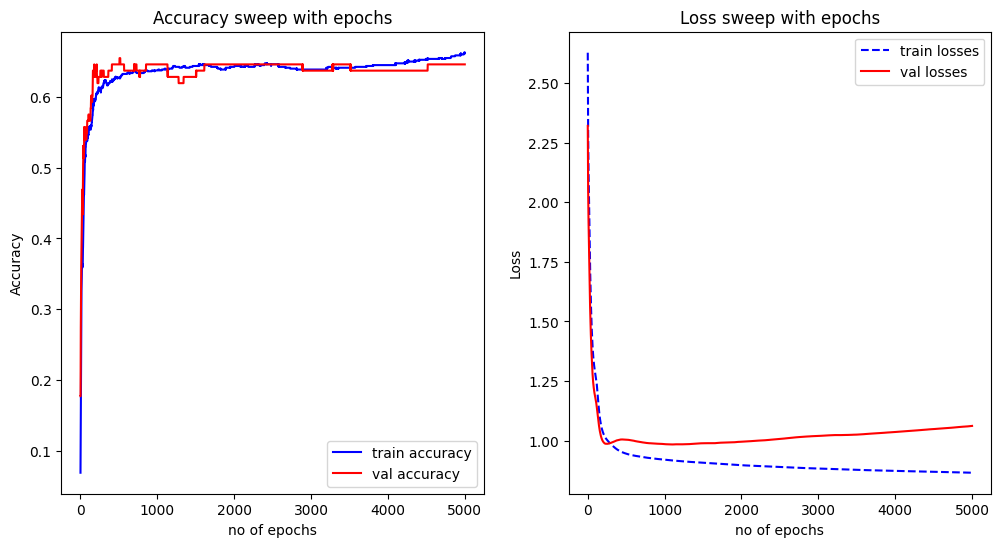

In [12]:
val_accuracy = model.val_accuracy
val_loss = model.val_loss
train_accuracy = model.train_accuracy
train_loss = model.train_loss

v_epochs = range(1, 5000+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='-', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train losses')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [13]:
model = MLP(X=X_train, y=y_train, X_val=X_val, y_val=y_val, learning_rate=0.0001, max_epochs=2500, optimizer='mini-batch', hidden_layers= 1, activation_func='relu')
model.fit()
y_pred = model.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print(accuracy)
# print(y_pred)

0.6460176991150443


Text(0.5, 1.0, 'Loss sweep with epochs')

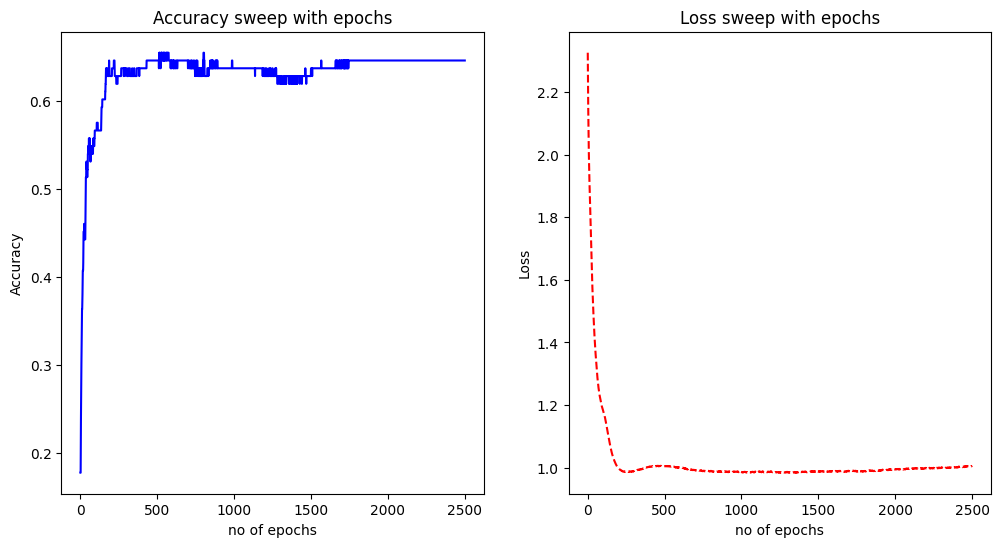

In [14]:
accuracies = model.val_accuracy
losses = model.val_loss

v_epochs = range(1, 2500+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, accuracies, color= 'blue', linestyle='-', label='accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.subplot(1, 2, 2)
plt.plot(v_epochs, losses, color='red', linestyle='--', label='losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')

In [15]:
model = MLP(X=X_train, y=y_train, X_val=X_val, y_val=y_val, learning_rate=0.00001, max_epochs=1000, optimizer='mini-batch', hidden_layers= 2, activation_func='relu')
model.fit()
y_pred = model.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print(accuracy)

0.6194690265486725


Text(0.5, 1.0, 'Loss sweep with epochs')

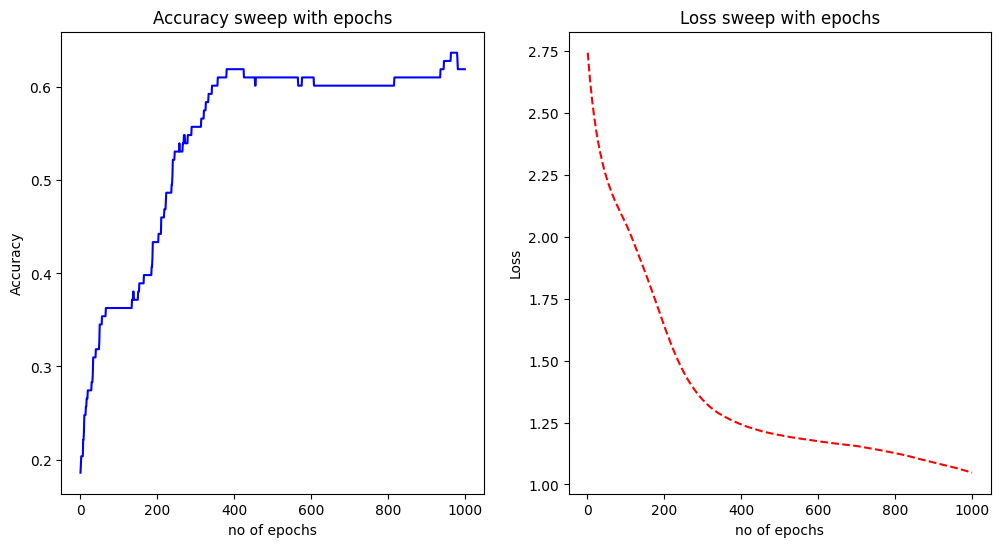

In [16]:
accuracies = model.val_accuracy
losses = model.val_loss

v_epochs = range(1, 1000+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, accuracies, color= 'blue', linestyle='-', label='accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.subplot(1, 2, 2)
plt.plot(v_epochs, losses, color='red', linestyle='--', label='losses')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')

In [17]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "epochs": {"values": [7500, 5000, 2500, 1000]},
        "lr": {"values": [0.0001, 0.00025, 0.0005, 0.001, 0.005]},
        "activation_func": {"values": ['sigmoid', 'relu', 'tanh']},
        "optimizer": {"values": ['batch', 'sgd', 'mini-batch']},
        "hidden_layer_neurons": {"values": [5, 8, 10, 12]},
        "hidden_layers": {"values": [1, 2, 3, 4]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="2.2-mlp-classification")

def tuning():
    run = wandb.init()

    lr = wandb.config.lr
    epochs = wandb.config.epochs
    activation_func = wandb.config.activation_func
    optimizer = wandb.config.optimizer
    hidden_layer_neurons = wandb.config.hidden_layer_neurons
    hidden_layers = wandb.config.hidden_layers

    # for epoch in np.arange(epochs-10, epochs):
    model = MLP(X_train, y_train, X_val=X_val, y_val=y_val, learning_rate=lr, max_epochs=epochs, activation_func=activation_func, optimizer=optimizer, hidden_layer_neurons=hidden_layer_neurons, hidden_layers=hidden_layers)
    model.fit()

    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = model.val_accuracy
    losses = model.val_loss
    v_epochs = range(1, epochs+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})


wandb.agent(sweep_id, function=tuning, count=50)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: yx6ktgw8
Sweep URL: https://wandb.ai/anushka-agrawal/2.2-mlp-classification/sweeps/yx6ktgw8


wandb: Agent Starting Run: v0pv1jjz with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.30809


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rds1u3ha with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.64743


wandb: Agent Starting Run: nrpqkeo7 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.64723


wandb: Agent Starting Run: 578qt4n2 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▃▃▅▇▂▆▂▅▆▅▆▆█▆▅▅▆▃▅▆▅▅▅▂▆▆▅▅▅▆▃▃▂▆▂▁▃▂▁▆
loss,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇
accuracy,0.63717
loss,1.23175


wandb: Agent Starting Run: 0krk3uo5 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█▄▄▂▁▁▁▂▄▂▁▁▂▂▄▄▄▄▂▄▄▅▅▂▂▂▄▁▂▁▅▂▁▁▂▇▂▅▂▂
loss,▄▂▁▁▁▁▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇█▇███████▇▇▇▇▇
accuracy,0.58407
loss,1.3151


wandb: Agent Starting Run: 3zx2vuoz with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.61807


wandb: Agent Starting Run: 5fm2yogo with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


C:\Users\hp\AppData\Local\Temp\ipykernel_15168\1994160377.py:62: RuntimeWarning: overflow encountered in exp
  x = 1/(1+np.exp(-x))


accuracy,█▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
loss,█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.28319
loss,1.59756


wandb: Agent Starting Run: 3dr22f7h with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇██████████████
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.59292
loss,1.60201


wandb: Agent Starting Run: wbn4r6v2 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▅▇▅█▇▂▅▅▅▄▅▅▅▆▆▆▅▆▆▇▅▅▄▅▃▁▇▃▅▄▄▄▄▇▅▄█▄▃▄
loss,▂▂▂▃▄▅▅▃▄▄▅▅▅▅▅▆▅▅▅▄▂▄▄▄▄█▁▁▁▁▂▃▃▁▃▃▁▃▃▂
accuracy,0.53982
loss,1.11226


wandb: Agent Starting Run: kybkk48o with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.31541


wandb: Agent Starting Run: r7bz4sv6 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▃▆▆▇▇▇██▇▇▇█████████████████████████
loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,1.24997


wandb: Agent Starting Run: y8zkav96 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇▇▇▇██▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,0.91591


wandb: Agent Starting Run: yshfigne with config:
wandb: 	activation_func: relu
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▆▆▆▅▅▅▇▇▇▇▇▇
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
accuracy,0.63717
loss,1.08319


wandb: Agent Starting Run: fd7eq42b with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.30809


wandb: Agent Starting Run: 3pmtrvoa with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▆▆▇
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
accuracy,0.62832
loss,1.20879


wandb: Agent Starting Run: dnyzq072 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 0.001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▄▆▇▇▇▇▇▇▇▇█████████████████████▇▇▇▇▇▇▇
loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.59292
loss,1.59914


wandb: Agent Starting Run: uoh6lspb with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇██████████████
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.59292
loss,1.60201


wandb: Agent Starting Run: i6vv1br3 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 1
wandb: 	lr: 0.00025
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▄▆▇▇▇▇▇▇▇███████████████████████████
loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,1.24777


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ip0fm3eo with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.64845


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1cwdabo with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▇▇▆▆▇▇▆▇▆▇▅▆▇█▇▇▇▇█▇▄▆▆▆▆▄▄▄▅▃▄▄▅▅▅▇▃▂▃▁
loss,▆▅▅▆▇█▇███▂▂▂▁▂▂▂▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄
accuracy,0.53982
loss,1.14516


wandb: Agent Starting Run: l5lqez36 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.30809


wandb: Agent Starting Run: 1f8a50c1 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 3
wandb: 	lr: 0.00025
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.30958


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0dullnbu with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▄▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇██████████████████████
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.63717
loss,1.59855


wandb: Agent Starting Run: 7111r0qs with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.00025
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.31587


wandb: Agent Starting Run: 8cgs9ynh with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇██████▇█████████████
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,1.59643


wandb: Agent Starting Run: e8s2f5ss with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.00025
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.64743


wandb: Agent Starting Run: oh4jfpd6 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 2
wandb: 	lr: 0.001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▆▇█▇▆▅▆▅▅▅▃▄▄▄▃▃▄▃▅▃▁▄▃▄▂▃▄▂▄▃▄▃▆▃▄▄▅▄▅▃
loss,▁▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▇▆▇▆▆▇▆▇▆▇▇█▆▆▇▇▆▆▇
accuracy,0.61947
loss,1.37722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qg0bcy0f with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▄▄▄▄▅▄▁█▅▆▇▇██▅▇▆▇▇▅▇█▆▇▅▆█▇▆█▇█▆▇█▅▆▅▇█
loss,▂▁▁▂▃▃█▆▃▅▅▅█▅▆▇▆▆█▅▆▇▅▇▇▆▇▅▇▆█▇█▅▇▆▅▆▅█
accuracy,0.62832
loss,1.56215


wandb: Agent Starting Run: 8zvh46p9 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 0.005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▆▆▆▅▅▅▅▆▆▆▆▆▇▇█▇▇██▅▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁
loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.49558
loss,1.59199


wandb: Agent Starting Run: 10pjy6vl with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.31107


wandb: Agent Starting Run: glkpyfwu with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆▆▇▇▇█████████▇▇▇
loss,█▆▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.52212
loss,1.59721


wandb: Agent Starting Run: aeyjrqbt with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 2
wandb: 	lr: 0.00025
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
loss,█▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁
accuracy,0.40708
loss,1.23294


wandb: Agent Starting Run: bhvbfgm6 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 0.005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▄▆▇▇████▇▇▇██████████████████
loss,█▅▅▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.53982
loss,1.59527


wandb: Agent Starting Run: 3nhr2n1r with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.3085


wandb: Agent Starting Run: m7ivlvf3 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▄▆▆▆█████████▇▆▆▄▄▅▅▅▆▆▆▅▄▃▂▁▁▁▁▂▁▂▂▁▁▁
loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
accuracy,0.47788
loss,1.59109


wandb: Agent Starting Run: wivh2ego with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆▇▇▆▅▅▅▆▆▆▆▇▇▇████▇▇▇▇▇
loss,█▇▆▆▆▅▅▅▅▅▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.65487
loss,1.18028


wandb: Agent Starting Run: zz3hvk6e with config:
wandb: 	activation_func: relu
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▆▅██▇▅▅▅▆▆▅▆▆▆▅▅▄▅▅▅▆▃▂▅▅█▇▅▅▆▆▅▅▅▃█▄▁▃▄
loss,▃▄▁▁▂▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▄▆▆▇▇▆▇███▆▇▇▇▇█▇▇
accuracy,0.57522
loss,1.33226


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: javdjpz4 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 0.001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▆▇█▇▅▅▅▅▆▁▁▆█▅▇▆▆▆▅▅▅▅▅▅▅▅▅▆▇▅▇▄▇▅▅▇▅▅▅▅
loss,▄▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇█▇▇▇███▇███████
accuracy,0.59292
loss,1.2827


wandb: Agent Starting Run: hbw85uf4 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▆▇▆▅▅▇▇▇▇█▇██▇▇▅▅▆▅▅▅▅▇▅▅▆▆▅▅▅▅▂▅▅▅▆▆▆
loss,▅▄▃▂▁▁▁▁▁▁▂▂▃▃▄▄▄▅▆▆▆▆▆▆▆▆▇▇█████▅▃▂▃▄▄▆
accuracy,0.56637
loss,1.31588


wandb: Agent Starting Run: 8rntsaca with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,██▅▄▂▃▅▃▃▂▁▃▅▃▄▅▃▂▅▄▁▅▃▃▅▂▄▄▅▃▃▅▂▃▁▄▄▄▂▄
loss,▁▂▄▃▅▆▅▆▇▇▇▅▅▇▆▅▇▇▆▄▅▃▄▇▅▇▇▆▇▆▆▄█▇▆▇▆█▅▇
accuracy,0.51327
loss,1.88467


wandb: Agent Starting Run: o5qydijy with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.30955


wandb: Agent Starting Run: rm2egv2q with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 1
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▂▃▅▅▆▆▆▆▆▆▇█████▇▆▆▆▇▆▆▇▆▆▆▆▆▅▅▅▅▄▅▃▃▂▁▁
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.49558
loss,1.59565


wandb: Agent Starting Run: r4jiicxf with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▇█▇▇▆▇▆▆▆▇▇▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇▆▇
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
accuracy,0.62832
loss,0.97384


wandb: Agent Starting Run: hlchp371 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▄▇▇▆▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▂▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃
accuracy,0.63717
loss,1.26512


wandb: Agent Starting Run: u6eli127 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.00025
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅█▇█▇▇▇▇▇▇███████▇█████████████████████
loss,█▄▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.64602
loss,1.22765


wandb: Agent Starting Run: 32d1unpw with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 1
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▃▅▆▆▆▅▄▃▁▁▃▅▅▆▇▇▇████████▇▇██▇▇▇▇▇▇▇▇▇▇▇
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.63717
loss,1.58542


wandb: Agent Starting Run: hne6b9d4 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 3
wandb: 	lr: 0.00025
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.37168
loss,1.3098


wandb: Agent Starting Run: jzirfkrz with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▆▇▇▇▇▇████████████████████████████████
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62832
loss,1.25661


wandb: Agent Starting Run: ezkvh5s8 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2500
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.00025
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▅
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄
accuracy,0.61062
loss,1.08111


wandb: Agent Starting Run: yzqeebjf with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 7500
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▃▃▃▄▄▅▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▆▆▆▆▆▇█████████
loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.56637
loss,1.60365


the link to my Wandb Report for hyperparameter tuning:
https://api.wandb.ai/links/anushka-agrawal/9yrn9tef

In [295]:
optimizers = ['batch', 'sgd', 'mini-batch']
activation_funcs = ['sigmoid', 'relu', 'tanh']

for activation in activation_funcs:
    for optimizer in optimizers:
        model = MLP(X=X_train, y=y_train, X_val = X_val, y_val= y_val, learning_rate=0.0005, max_epochs=2500, optimizer=optimizer, hidden_layers= 1, activation_func=activation)
        model.fit()

        y_pred = model.predict(X_val)
        classification_metric = classification_report(y_val, y_pred, zero_division=0)
        print("Classification report for activation function: ", activation, " and optimizer: ", optimizer)
        print(classification_metric)

Classification report for activation function:  sigmoid  and optimizer:  batch
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2
           5       0.65      0.86      0.74        42
           6       0.66      0.68      0.67        56
           7       0.00      0.00      0.00        13

    accuracy                           0.65       113
   macro avg       0.33      0.38      0.35       113
weighted avg       0.57      0.65      0.61       113

Classification report for activation function:  sigmoid  and optimizer:  sgd
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         2
           5       0.65      0.86      0.74        42
           6       0.66      0.68      0.67        56
           7       0.00      0.00      0.00        13

    accuracy                           0.65       113
   macro avg       0.33      0.38      0.35       113
weighted avg       0.57      

In [12]:
learning_rates = [0.0001, 0.0002, 0.0005, 0.001]
epochs = [2500, 1000]
hidden_layer_neurons = [8, 10, 12]
hidden_layers = [1, 2, 3]

learning_rates_ = []
epochs_ = []
hidden_layer_neurons_ = []
hidden_layers_ = []

accuracies = []
f1_score_macro = []
f1_score_micro = []
f1_score_weighted = []
precisions = []
recalls = []

for lr in learning_rates:
    for epoch in epochs:
        for neuron in hidden_layer_neurons:
            for layer in hidden_layers:
                model = MLP(X=X_train, y=y_train, X_val = X_val, y_val= y_val, learning_rate=lr, max_epochs=epoch, optimizer='mini-batch', hidden_layers= layer, activation_func='relu', hidden_layer_neurons=neuron)
                model.fit()

                y_pred = model.predict(X_val)
                
                accuracy = accuracy_score(y_val, y_pred)
                f1_score_macro_ = f1_score(y_val, y_pred, average='macro', zero_division=1)
                f1_score_micro_ = f1_score(y_val, y_pred, average='micro', zero_division=1)
                f1_score_weighted_ = f1_score(y_val, y_pred, average='weighted', zero_division=1)
                precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
                recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
                learning_rates_.append(lr)
                epochs_.append(epoch)
                hidden_layer_neurons_.append(neuron)
                hidden_layers_.append(layer)
                accuracies.append(accuracy)
                f1_score_macro.append(f1_score_macro_)
                f1_score_micro.append(f1_score_micro_)
                f1_score_weighted.append(f1_score_weighted_)
                precisions.append(precision)
                recalls.append(recall)

In [17]:
dataframe = pd.DataFrame({
    'learning rate': learning_rates_,
    'epochs': epochs_,
    'hidden layer neurons': hidden_layer_neurons_,
    'hidden layers': hidden_layers_,
    'accuracy': accuracies,
    'f1_score_macro': f1_score_macro,
    'f1_score_micro': f1_score_micro,
    'f1_score_weighted': f1_score_weighted,
    'precision': precision,
    'recall': recall
})

df = pd.DataFrame(dataframe)
df

,learning rate,epochs,hidden layer neurons,hidden layers,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,precision,recall
0,0.0001,2500,8,1,0.628319,0.447737,0.628319,0.620484,1.0,0.0
1,0.0001,2500,8,2,0.646018,0.698223,0.646018,0.657318,1.0,0.0
2,0.0001,2500,8,3,0.584071,0.401281,0.584071,0.572247,1.0,0.0
3,0.0001,2500,10,1,0.654867,0.704245,0.654867,0.665566,1.0,0.0
4,0.0001,2500,10,2,0.672566,0.453310,0.672566,0.656976,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
67,0.0010,1000,10,2,0.000000,0.200000,1.000000,0.371681,1.0,0.0
68,0.0010,1000,10,3,0.000000,0.000000,1.000000,0.000000,1.0,0.0
69,0.0010,1000,12,1,0.584071,0.380259,0.584071,0.571011,1.0,0.0
70,0.0010,1000,12,2,0.000000,0.000000,1.000000,0.000000,1.0,0.0


In [45]:
model = MLP(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='mini-batch', learning_rate=0.0001, max_epochs=2500, hidden_layers=1, hidden_layer_neurons=8)
model.fit()
y_pred = model.predict(X_test)
# print(y_pred)

classification_metrics = classification_report(y_test, y_pred, zero_division=1)
print(classification_metrics)

              precision    recall  f1-score   support

           4       1.00      0.00      0.00         7
           5       0.68      0.75      0.72       101
           6       0.59      0.61      0.60        90
           7       0.56      0.50      0.53        28
           8       1.00      0.00      0.00         4

    accuracy                           0.63       230
   macro avg       0.77      0.37      0.37       230
weighted avg       0.65      0.63      0.61       230



Comparing the performance of Multinomial Logistic Regression (MLR) and a Multi-Layer Perceptron (MLP) by assessing metrics like accuracy, precision, recall, and F1-score on the dataset, we observe that both the model gives us similar performance with accuracy of around 62-63%. Though MLP can capture complex non-linear relationship using multiple hidden layer and activation function, it doesn't do much good on this dataset. Using multiple hidden layers cause overfitting which reduces the performance of the model.

### MULTI LABEL CLASSIFICATION USING MLP

In [10]:
data_ad = pd.read_csv('advertisement.csv')
data_ad.head()

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home


In [11]:
labels_split = data_ad['labels'].str.split()
# labels_split

mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(labels_split)
# encoded_labels.shape()

In [12]:
categorical_columns = ["gender", "education", "married", "city", "occupation", "most bought item"]

for col in categorical_columns:
    le = LabelEncoder()
    data_ad[col] = le.fit_transform(data_ad[col])

encoded_features = data_ad.drop(columns=['labels']).values
encoded_features = scaler.fit_transform(encoded_features)

In [13]:
X_ad = encoded_features
y_ad = encoded_labels

X_train, X_test, y_train, y_test = train_test_split(encoded_features, encoded_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [14]:
class MLP_MultiLabel:
    def __init__(self, X, y, X_val, y_val, activation_func = 'sigmoid', optimizer = 'batch', learning_rate = 0.01, max_epochs = 5000, hidden_layer_neurons = 10, hidden_layers = 1):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y
        self.X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)
        self.y_val = y_val
        self.activation_func = activation_func
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.hidden_layer_neurons = hidden_layer_neurons
        self.n_hidden_layers = hidden_layers
        self.n_classes = self.y.shape[1]
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [self.hidden_layer_neurons] * self.n_hidden_layers + [self.y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_accuracy = list()
        self.val_loss = list()
        self.val_accuracy = list()

    def __init_weights(self):
        self.weights = list()
        self.biases = list()
        np.random.seed(42)
        if self.activation_func == 'relu':
            for i in range(self.layer_sizes.shape[0] - 1):
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2.0 / self.layer_sizes[i]))
                self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
            return 
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(1.0 / self.layer_sizes[i]))
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
        
    def __init_layers(self, batch_size):
        self.hidden_layers_z = [np.empty((batch_size, layer)) for layer in self.layer_sizes]
        self.hidden_layers_a = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __activation(self, x):
        if(self.activation_func=='sigmoid'):
            return 1 / (1 + np.exp(-np.clip(x, -100, 100)))
        if(self.activation_func=='relu'):
            return np.maximum(0, x)
        if(self.activation_func=='tanh'):
            return np.tanh(x)
    
    def __activation_prime(self, x):
        if(self.activation_func=='sigmoid'):
            x = 1/(1+np.exp(-np.clip(x, -100, 100)))
            return np.multiply(x, (1 - x))
        if(self.activation_func=='relu'):
            return np.where(x <= 0, 0., 1.)
        if(self.activation_func=='tanh'):
            x = np.tanh(x)
            return 1 - x**2
        
    def __sigmoid(self, x):
        # return 1/(1+np.exp(-x))
        return 1/(1+np.exp(-np.clip(x, -100, 100)))
    
    
    def __loss(self, y, y_pred):
        epi = 1e-10
        y_pred = np.clip(y_pred, epi, 1-epi)
        return -1/(self.batch_size * self.n_classes) * np.sum(y*np.log(y_pred) + ((1-y)*np.log(1-y_pred)))
    
    def __accuracy(self, y, y_pred):
        y_pred_label = np.where(y_pred>=0.5, 1, 0)
        return np.mean(y_pred_label == y)
    
    def __forward_propagation(self, x):
        input = x
        self.hidden_layers_a[0] = input
        for i, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            self.hidden_layers_z[i+1] = np.dot(input, weights) + bias
            input = self.__activation(self.hidden_layers_z[i+1])
            self.hidden_layers_a[i+1] = input
        self.output_layer = self.__sigmoid(self.hidden_layers_z[-1])

    def __backward_propagation(self, y):
        delta = (self.output_layer - y)
        for i in range(1, len(self.weights)+1):
            self.weights[-i] -= self.learning_rate * np.dot(self.hidden_layers_a[-i-1].T, delta)
            self.biases[-i] -= self.learning_rate * np.sum(delta, axis=0, keepdims=True)
            delta_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta, self.weights[-i].T)
            delta = delta_

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.__init_layers(X.shape[0]) 
        self.__forward_propagation(X)
        return np.where(self.output_layer>=0.5, 1, 0)
    
    def train(self, batch_size = 8):
        self.batch_size = batch_size
        for epoch in range(self.max_epochs):
            self.__init_layers(batch_size)
            shuffle = np.random.permutation(self.n_samples)

            X_shuffled = self.X[shuffle]
            y_shuffled = self.y[shuffle]
            train_loss = 0
            train_accuracy = 0
            no_of_batches = 0
            # for x_batch, y_batch in zip(X_batches, Y_batches):
            for i in range(0, self.n_samples, batch_size):

                if(self.n_samples - i <batch_size):
                    continue
                x_batch = X_shuffled[i:i+batch_size, :]
                y_batch = y_shuffled[i:i+batch_size, :]
                self.__forward_propagation(x_batch)
                train_loss += self.__loss(y_batch, self.output_layer)
                train_accuracy += self.__accuracy(y_batch, self.output_layer)
                self.__backward_propagation(y_batch)
                no_of_batches += 1

            train_loss /= no_of_batches
            train_accuracy /= no_of_batches
            self.train_loss.append(train_loss)
            self.train_accuracy.append(train_accuracy)

            self.__init_layers(self.X_val.shape[0])
            self.__forward_propagation(self.X_val)
            val_loss = self.__loss(self.y_val, self.output_layer) * self.batch_size / self.X_val.shape[0]
            val_accuracy = self.__accuracy(self.y_val, self.output_layer)

            self.val_loss.append(val_loss)
            self.val_accuracy.append(val_accuracy)

    def fit(self):
        if(self.optimizer=='sgd'):
            self.train(batch_size=1)
        if(self.optimizer=='mini-batch'):
            self.train(batch_size=32)
        if(self.optimizer=='batch'):
            self.train(batch_size=self.n_samples)

In [15]:
model = MLP_MultiLabel(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='batch', learning_rate=0.0001, max_epochs=3000, hidden_layers=1, hidden_layer_neurons=11)
model.fit()

y_pred = model.predict(X_val)
print(np.sum(y_pred))
print(accuracy_score(y_pred, y_val))

143
0.03333333333333333


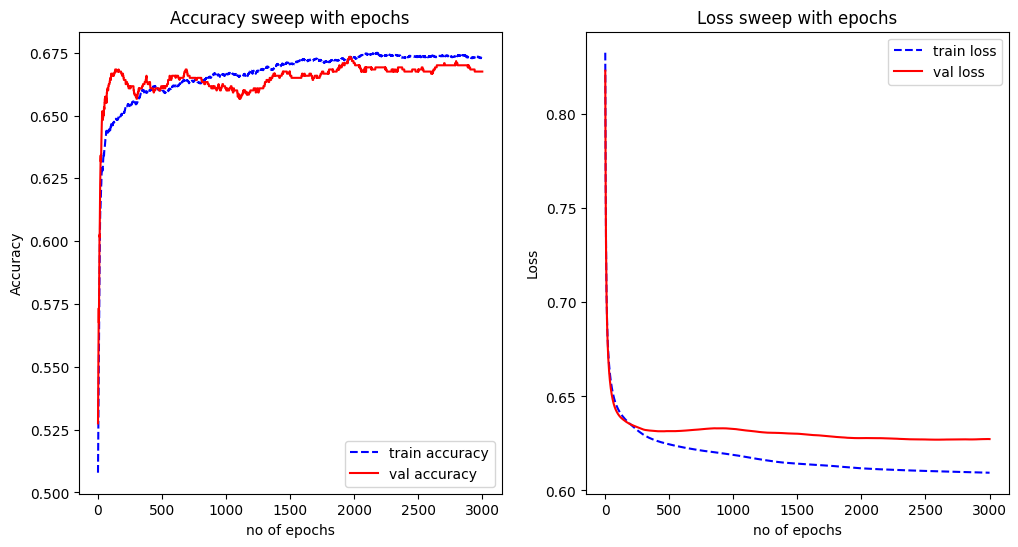

In [16]:
val_accuracy = model.val_accuracy
train_accuracy = model.train_accuracy
# print(accuracies)
val_loss = model.val_loss
train_loss = model.train_loss
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train loss')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [17]:
model = MLP_MultiLabel(X_train, y_train, X_val, y_val, activation_func='tanh', optimizer='batch', learning_rate=0.00001, max_epochs=1000, hidden_layers=3, hidden_layer_neurons=11)
model.fit()

y_pred = model.predict(X_val)
print(np.mean(y_pred == y_val))

0.6725


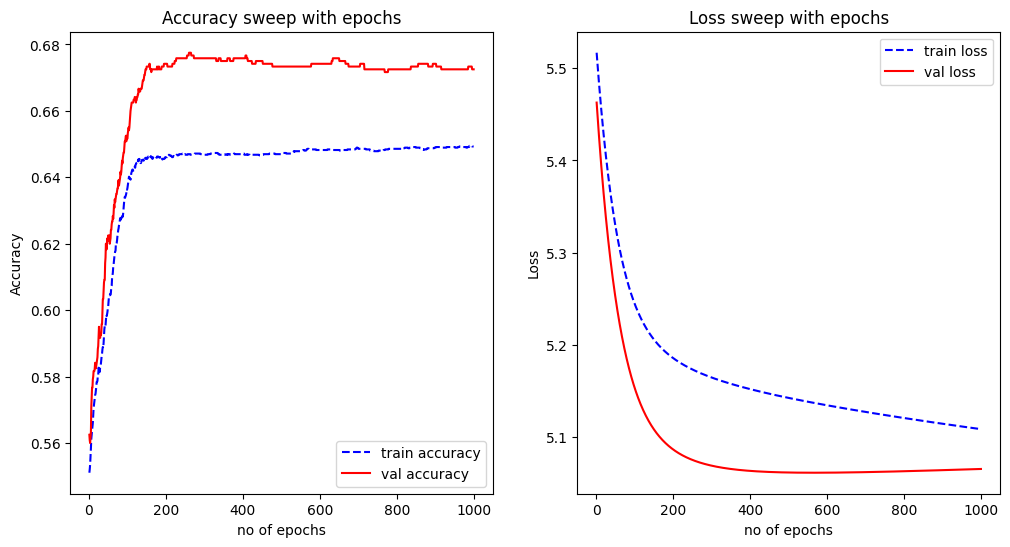

In [26]:
val_accuracy = model.val_accuracy
train_accuracy = model.train_accuracy
# print(accuracies)
val_loss = model.val_loss
train_loss = model.train_loss
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train loss')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [27]:
model = MLP_MultiLabel(X_train, y_train, X_val, y_val, activation_func='tanh', optimizer='batch', learning_rate=0.00001, max_epochs=3000, hidden_layers=2, hidden_layer_neurons=11)
model.fit()

y_pred = model.predict(X_val)
print(np.mean(y_pred == y_val))

0.6716666666666666


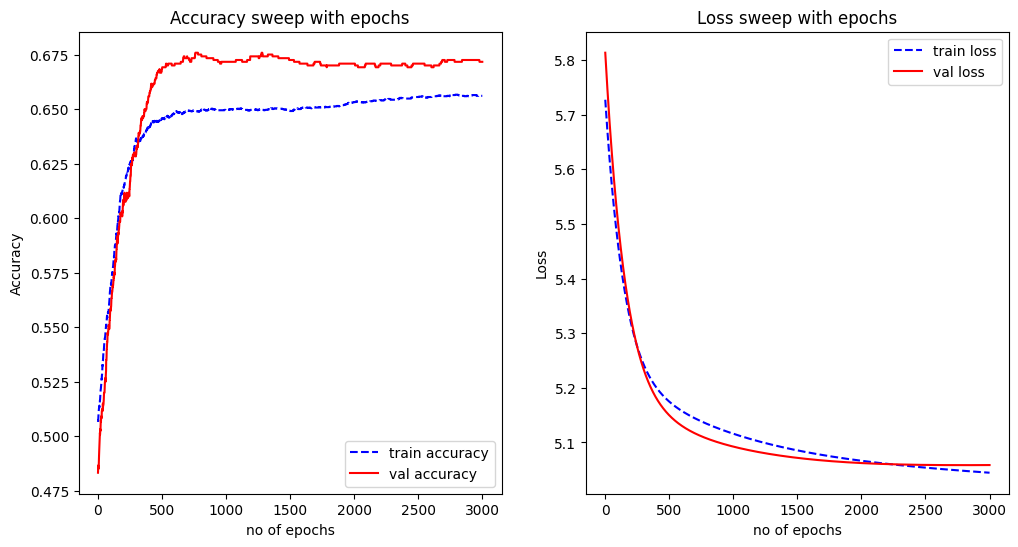

In [28]:
val_accuracy = model.val_accuracy
train_accuracy = model.train_accuracy
# print(accuracies)
val_loss = model.val_loss
train_loss = model.train_loss
v_epochs = range(1, len(val_accuracy)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v_epochs, train_accuracy, color= 'blue', linestyle='--', label='train accuracy')
plt.plot(v_epochs, val_accuracy, color= 'red', linestyle='-', label='val accuracy')
plt.xlabel('no of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy sweep with epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train loss')
plt.plot(v_epochs, val_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [25]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "epochs": {"values": [5000, 3000, 2000, 1000]},
        "lr": {"values": [0.00001, 0.00005, 0.0001, 0.0002, 0.0005]},
        "activation_func": {"values": ['sigmoid', 'relu', 'tanh']},
        "optimizer": {"values": ['batch', 'sgd', 'mini-batch']},
        "hidden_layer_neurons": {"values": [5, 8, 10, 12]},
        "hidden_layers": {"values": [1, 2, 3, 4]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="2.4-mlp-multilabel-classification")

def tuning():
    run = wandb.init()

    lr = wandb.config.lr
    epochs = wandb.config.epochs
    activation_func = wandb.config.activation_func
    optimizer = wandb.config.optimizer
    hidden_layer_neurons = wandb.config.hidden_layer_neurons
    hidden_layers = wandb.config.hidden_layers

    # for epoch in np.arange(epochs-10, epochs):
    model = MLP_MultiLabel(X_train, y_train, X_val=X_val, y_val=y_val, learning_rate=lr, max_epochs=epochs, activation_func=activation_func, optimizer=optimizer, hidden_layer_neurons=hidden_layer_neurons, hidden_layers=hidden_layers)
    model.fit()

    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    accuracies = model.val_accuracy
    losses = model.val_loss
    v_epochs = range(1, epochs+1)
    for accuracy, loss, epoch_count in zip(accuracies, losses, v_epochs):
        wandb.log({"accuracy": accuracy, "loss": loss})


wandb.agent(sweep_id, function=tuning, count=41)

Create sweep with ID: pecfgu1y
Sweep URL: https://wandb.ai/anushka-agrawal/2.4-mlp-multilabel-classification/sweeps/pecfgu1y


wandb: Agent Starting Run: 1gy7wuin with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 5e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63018


wandb: Agent Starting Run: yqbe8q37 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▆█████▇▆▇▆▆▆▄▄▅▃▄▃▃▃▃▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅
accuracy,0.65583
loss,0.64049


wandb: Agent Starting Run: 4ncnvuw8 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0002
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▆▇▇▇▇██▇▇▇▇▇▆▆▆▅▅▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▂
loss,█▄▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
accuracy,0.66833
loss,0.62828


wandb: Agent Starting Run: nivcjbq1 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
loss,███████▇████████▇███████▇▇██▇▇█▇▇▆▅▄▂▁▁▃
accuracy,0.68167
loss,0.62657


wandb: Agent Starting Run: obhijs19 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 4
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▂▂▂▂▆▆▆██████████████████████████████
loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63038


wandb: Agent Starting Run: 3htes68j with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇██████████████████████████████████████
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
accuracy,0.67167
loss,0.63303


wandb: Agent Starting Run: g8823r3l with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▁▁
accuracy,0.68
loss,0.62596


wandb: Agent Starting Run: kde5ez73 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▇█████████████████████████████████████
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63018


wandb: Agent Starting Run: d9yogjzt with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▅▅▆▆▇▇▇▇██████████████████████████████
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.675
loss,0.62407


wandb: Agent Starting Run: lzzfllok with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▇▇▇▇▇▇▇███▆▇█▇▇▇▇▆▆▆▆▅▅▅▄▃▂▂▁▂▂▂▂▁▁▁▁▂▁▁
loss,█▄▃▂▂▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
accuracy,0.66583
loss,0.63328


wandb: Agent Starting Run: x2kbqflq with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,██████▇▇▇▆▆▆▅▅▅▅▅▅▆▅▄▃▃▃▃▃▃▄▄▃▄▄▄▃▂▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▅▅▆▆▇▇▇▇████████████
accuracy,0.6675
loss,0.6491


wandb: Agent Starting Run: o10k7kfw with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█▇█▅▂▁▁▃▂▁▁▂▂▂▃▂▃▃▄▄▄▃▂▃▄▄▅▅▅▅▄▅▅▆▆▆▆▅▅▅
loss,▁▂▂▄▆▇█████████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇
accuracy,0.66167
loss,0.64866


wandb: Agent Starting Run: zq34pub2 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,▁█
accuracy,0.68
loss,nan


wandb: Agent Starting Run: wli0uhg8 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▄▅▇▇▇▇▇▇▇██████████████████████████████
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68333
loss,0.61902


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hk6xwpx6 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 3
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▅███████████▇▇▇▆▆▆▅▅▅▅▅▄▄▅▄▄▃▃▃▃▃▂▂▁▂▁▁▁
loss,▃▂▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
accuracy,0.64
loss,0.68273


wandb: Agent Starting Run: otbgbtrh with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


C:\Users\hp\AppData\Local\Temp\ipykernel_5448\1681000583.py:89: RuntimeWarning: invalid value encountered in multiply
  delta_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta, self.weights[-i].T)


accuracy,█▄▁█████████████████████████████████████
loss,▁▄█
accuracy,0.68
loss,nan


wandb: Agent Starting Run: d3zsnxk6 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0002
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,███▇███████▇▆▆▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
loss,█▄▃▂▁▁▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅
accuracy,0.65667
loss,0.63126


wandb: Agent Starting Run: t5plflez with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,███████████████████████████████▇▅▁▁▂▂▅▇▇
loss,▇▇▇▇▇▇▇▇▇██████████████████████▇▆▅▄▃▂▁▁▁
accuracy,0.67917
loss,0.6277


wandb: Agent Starting Run: hf2gyc6g with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▆▇██████████████████████▇█▇▇████▇▇▇████
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.6725
loss,0.62864


wandb: Agent Starting Run: 9f9r4pqc with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,███▇▇▆▇▆▅▃▄▄▃▄▃▃▄▃▄▄▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▄▃▃▄
loss,▅▂▂▁▁▁▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▅▆▆▆▇▇▇█████████▇▇▇
accuracy,0.66667
loss,0.63532


wandb: Agent Starting Run: v7e3d0t3 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0002
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▃▂▂▃▁▃▃▂▄▄▄▂▃▂▄▃▃▃▃▂▃▃▁▃▄▃▃▄▄▂▂▃▃▃▃▃▃
accuracy,0.68
loss,0.63021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s5wnm1yk with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▆▇▇███████████████████████████████████
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.67417
loss,0.63542


wandb: Agent Starting Run: c53cqzl5 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▃▅▅▆▇▇▇▇▇▇▇▇██████████████████████████
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.67083
loss,0.63565


wandb: Agent Starting Run: 4fjdqr6n with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0002
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▅██▇████▇▆▆▆▆▅▄▃▃▂▃▃▃▃▃▃▂▃▃▃▃▁▁▁▃▃▄▃▃▅▄▆
loss,▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▅▇▆▇▆▇▅▇▆▆█▆
accuracy,0.65083
loss,0.77249


wandb: Agent Starting Run: er0l4iit with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 2
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▇▇▇▇▇▇▇▇██▇████████▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
accuracy,0.675
loss,0.62715


wandb: Agent Starting Run: w6oy4iwa with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,██▄▃▁▂██████████████████████████████████
loss,▁▁▃▆██
accuracy,0.68
loss,nan


wandb: Agent Starting Run: 1lpqsr8n with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇█▇▆▆▅▄▄▆▅▅▄▄▄▄▃▂▂▂▂▂▂▂▃▃▂▂▁▁▁▁▁▁▂▂▂▁▁▁
loss,█▃▁▁▁▂▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃
accuracy,0.65333
loss,0.63538


wandb: Agent Starting Run: 6jde75qn with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▇█████████████████████████████████████
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63018


wandb: Agent Starting Run: 2degchd2 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▄▆▇█▇▇▇▇████▇█▇█▆▇▆▆▅▅▄▃▄▃▂▂▂▁▁▁▁▁▂▂▁▂▁▂
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇
accuracy,0.65833
loss,0.64087


wandb: Agent Starting Run: pwkfj0be with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,██▇▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▁▁▁▂▂▁▃▂▂▂▂▂▃▂▃▃▂▃▄▃▃
loss,▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█▇▇██████████▇▇█
accuracy,0.6425
loss,0.6795


wandb: Agent Starting Run: 6nluwqbi with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 3
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▃▄▄▅▆▇▇▇▇▇█████████████████████████████
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.6725
loss,0.63633


wandb: Agent Starting Run: 9sl9nt44 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▁▄▄▄▄▄▄▅▇██████████████████████████████
loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qkid7fra with config:
wandb: 	activation_func: relu
wandb: 	epochs: 3000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█▇▅▄▁▅▄▅████████████████████████████████
loss,▁▁▃██▄▆█
accuracy,0.68
loss,nan


wandb: Agent Starting Run: 5lh0zngy with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█▇▆▁▁███████████████████████████████████
loss,▁▂▃▆█
accuracy,0.68
loss,nan


wandb: Agent Starting Run: xte60h8j with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 4
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▂▃▅▆▇▇█████████████████████████████████
loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.63366


wandb: Agent Starting Run: 7b9ygs21 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0002
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,█████▆▆▅▄▄▃▃▃▃▃▂▂▃▃▂▃▃▃▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁
loss,▄▃▁▁▂▃▄▅▆▆▆▇▇▆▆▆▆▆▆▆▆▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
accuracy,0.65083
loss,0.63398


wandb: Agent Starting Run: xnw70uad with config:
wandb: 	activation_func: relu
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 12
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇▄▅▇▇▆▅▆██▇▇▆▆▇▆▅▃▃▃▂▄▄▅▄▅▅▅▄▃▅▄▃▃▃▂▃▂▂
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▃▃
accuracy,0.66083
loss,0.63406


wandb: Agent Starting Run: 2wru97yr with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2000
wandb: 	hidden_layer_neurons: 8
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁█████▆▆▅▆▆▆▅▅▅▅▅▅▄▅▅▄▄▄▅▅▅▅▅▄▄▄▄▄▂▂▃▃▃▃
loss,█▂▂▁▁▁▂▂▂▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅
accuracy,0.66333
loss,0.64536


wandb: Agent Starting Run: 2d3yp3jj with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 1
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇█▇▆▆▅▄▄▆▅▅▄▄▄▄▄▂▁▁▂▂▂▂▂▃▂▂▁▁▁▁▁▂▁▂▁▁▁▁
loss,█▃▁▁▂▂▃▃▄▄▄▄▄▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
accuracy,0.6525
loss,0.6354


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nkazi1uf with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 5000
wandb: 	hidden_layer_neurons: 10
wandb: 	hidden_layers: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▇██████████████████████████████████████
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68
loss,0.62853


wandb: Agent Starting Run: 8fmjp5g5 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer_neurons: 5
wandb: 	hidden_layers: 4
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


accuracy,▁▅▆▇▇███████████████████████████████████
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.68333
loss,0.63201


The link to my wand report for logging the loss and accuracy:
https://api.wandb.ai/links/anushka-agrawal/aajq4eir

In [30]:
optimizers = ['batch', 'sgd', 'mini-batch']
activation_funcs = ['sigmoid', 'relu', 'tanh']

for activation in activation_funcs:
    for optimizer in optimizers:
        model = MLP_MultiLabel(X=X_train, y=y_train, X_val = X_val, y_val= y_val, learning_rate=0.0005, max_epochs=2500, optimizer=optimizer, hidden_layers= 1, activation_func=activation)
        model.fit()

        y_pred = model.predict(X_val)
        classification_metric = classification_report(y_val, y_pred, zero_division=1)
        print("Classification report for activation function: ", activation, " and optimizer: ", optimizer)
        print(classification_metric)

Classification report for activation function:  sigmoid  and optimizer:  batch
              precision    recall  f1-score   support

           0       0.36      0.12      0.19        40
           1       0.33      0.13      0.19        54
           2       0.26      0.15      0.19        47
           3       0.38      0.07      0.12        44
           4       0.31      0.12      0.18        41
           5       0.62      0.15      0.24        53
           6       0.00      0.00      1.00        50
           7       0.42      0.29      0.34        55

   micro avg       0.37      0.13      0.20       384
   macro avg       0.33      0.13      0.30       384
weighted avg       0.34      0.13      0.31       384
 samples avg       0.56      0.14      0.55       384

Classification report for activation function:  sigmoid  and optimizer:  sgd
              precision    recall  f1-score   support

           0       0.36      0.12      0.19        40
           1       0.35      0

In [32]:
learning_rates = [0.0001, 0.0005, 0.001]
epochs = [2500, 1000]
hidden_layer_neurons = [8, 10, 12]
hidden_layers = [1, 2, 3]

learning_rates_ = []
epochs_ = []
hidden_layer_neurons_ = []
hidden_layers_ = []

accuracies = []
f1_score_macro = []
f1_score_micro = []
f1_score_weighted = []
precisions = []
recalls = []

for lr in learning_rates:
    for epoch in epochs:
        for neuron in hidden_layer_neurons:
            for layer in hidden_layers:
                model = MLP_MultiLabel(X=X_train, y=y_train, X_val = X_val, y_val= y_val, learning_rate=lr, max_epochs=epoch, optimizer='mini-batch', hidden_layers= layer, activation_func='relu', hidden_layer_neurons=neuron)
                model.fit()

                y_pred = model.predict(X_val)
                
                accuracy = 1- hamming_loss(y_val, y_pred)
                f1_score_macro_ = f1_score(y_val, y_pred, average='macro', zero_division=1)
                f1_score_micro_ = f1_score(y_val, y_pred, average='micro', zero_division=1)
                f1_score_weighted_ = f1_score(y_val, y_pred, average='weighted', zero_division=1)
                precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
                recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
                learning_rates_.append(lr)
                epochs_.append(epoch)
                hidden_layer_neurons_.append(neuron)
                hidden_layers_.append(layer)
                accuracies.append(accuracy)
                f1_score_macro.append(f1_score_macro_)
                f1_score_micro.append(f1_score_micro_)
                f1_score_weighted.append(f1_score_weighted_)
                precisions.append(precision)
                recalls.append(recall)

C:\Users\hp\AppData\Local\Temp\ipykernel_9196\1681000583.py:89: RuntimeWarning: invalid value encountered in multiply
  delta_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta, self.weights[-i].T)
C:\Users\hp\AppData\Local\Temp\ipykernel_9196\1681000583.py:89: RuntimeWarning: invalid value encountered in multiply
  delta_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta, self.weights[-i].T)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\hp\AppData\Local\Temp\ipykernel_9196\1681000583.py:89: RuntimeWarning: invalid value encountered in multiply
  delta_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta, self.weights[-i].T)
c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encounte

In [33]:
dataframe = pd.DataFrame({
    'learning rate': learning_rates_,
    'epochs': epochs_,
    'hidden layer neurons': hidden_layer_neurons_,
    'hidden layers': hidden_layers_,
    'accuracy': accuracies,
    'f1_score_macro': f1_score_macro,
    'f1_score_micro': f1_score_micro,
    'f1_score_weighted': f1_score_weighted,
    'precision': precision,
    'recall': recall
})

df = pd.DataFrame(dataframe)
df

,learning rate,epochs,hidden layer neurons,hidden layers,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,precision,recall
0,0.0001,2500,8,1,0.681667,0.243203,0.268199,0.250308,1.0,0.0
1,0.0001,2500,8,2,0.666667,0.195438,0.218750,0.204923,1.0,0.0
2,0.0001,2500,8,3,0.660833,0.174181,0.197239,0.179736,1.0,0.0
3,0.0001,2500,10,1,0.654167,0.279613,0.171657,0.273228,1.0,0.0
4,0.0001,2500,10,2,0.670000,0.276870,0.282609,0.276148,1.0,0.0
5,0.0001,2500,10,3,0.647500,0.188328,0.197343,0.190976,1.0,0.0
6,0.0001,2500,12,1,0.666667,0.201274,0.215686,0.207661,1.0,0.0
7,0.0001,2500,12,2,0.645000,0.245794,0.260417,0.251007,1.0,0.0
8,0.0001,2500,12,3,0.660833,0.277163,0.292174,0.284789,1.0,0.0
9,0.0001,1000,8,1,0.670000,0.180818,0.201613,0.186237,1.0,0.0


In [19]:
model = MLP_MultiLabel(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='mini-batch', learning_rate=0.0001, max_epochs=2500, hidden_layers=2, hidden_layer_neurons=8)
model.fit()

y_pred = model.predict(X_test)
# print(y_pred)
accuracy = 1- hamming_loss(y_val, y_test)
f1_score_macro_ = f1_score(y_val, y_test, average='macro', zero_division=1)
f1_score_micro_ = f1_score(y_val, y_test, average='micro', zero_division=1)
f1_score_weighted_ = f1_score(y_val, y_test, average='weighted', zero_division=1)
precision = precision_score(y_val, y_test, average='weighted', zero_division=1)
recall = recall_score(y_val, y_test, average='weighted', zero_division=1)


print("Accuracy: ", accuracy)
print("F1 Score Macro: ", f1_score_macro_)
print("F1 Score Micro: ", f1_score_micro_)
print("F1 Score Weighted: ", f1_score_weighted_)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.5608333333333333
F1 Score Macro:  0.3268816888567325
F1 Score Micro:  0.3286624203821656
F1 Score Weighted:  0.3309186642955554
Precision:  0.3285532865655944
Recall:  0.3359375


# MLP REGRESSION

In [2]:
housing_data = pd.read_csv('HousingData.csv')
housing_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [3]:
housing_data.describe()
housing_data = housing_data[housing_data['MEDV'] != 50.0]

Text(0.5, 1.0, 'Histogram of Median value of owner-occupied homes')

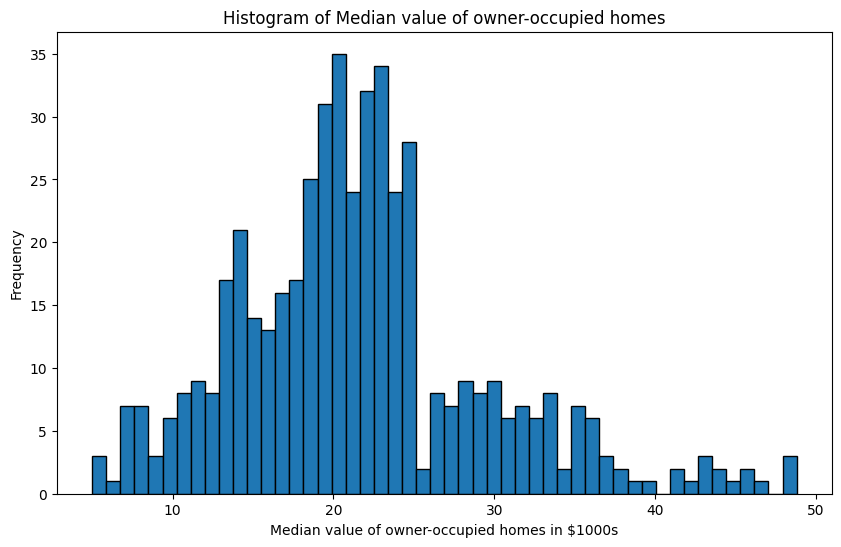

In [4]:
label_range = (housing_data['MEDV'].min(), housing_data['MEDV'].max())
num_bins = 50
labels = housing_data['MEDV'].values

plt.figure(figsize=(10, 6))
plt.hist(labels, bins=num_bins, range=label_range, edgecolor='black')
plt.xlabel('Median value of owner-occupied homes in $1000s')
plt.ylabel('Frequency')
plt.title('Histogram of Median value of owner-occupied homes')

In [5]:
means = housing_data.mean()

housing_data.fillna(means, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_10940\2444567500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_data.fillna(means, inplace=True)


In [6]:
X = housing_data.drop(columns=['MEDV']).values
y = housing_data['MEDV'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
# print(X)
y = y.tolist()
y = np.asarray(y)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [7]:
class MLP_regression:
    def __init__(self, X, y, X_val, y_val, activation_func = 'sigmoid', optimizer = 'batch', learning_rate = 0.01, max_epochs = 5000, hidden_layer_neurons = 10, hidden_layers = 1):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y.reshape(-1,1)
        self.X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)
        self.y_val = y_val.reshape(-1, 1)
        self.activation_func = activation_func
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.hidden_layer_neurons = hidden_layer_neurons
        self.n_hidden_layers = hidden_layers
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [self.hidden_layer_neurons] * self.n_hidden_layers + [self.y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_accuracy = list()
        self.val_loss = list()
        self.val_accuracy = list()

    def __init_weights(self):
        self.weights = list()
        self.biases = list()
        np.random.seed(42)
        if self.activation_func == 'relu':
            for i in range(self.layer_sizes.shape[0] - 1):
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(2.0 / self.layer_sizes[i]))
                self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
            return 
        if self.activation_func == 'sigmoid':
            for i in range(self.layer_sizes.shape[0] - 1):
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * np.sqrt(1.0 / self.layer_sizes[i]))
                self.biases.append(np.zeros((1, self.layer_sizes[i+1])))
            return
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1/(math.sqrt(self.n_samples)), 1/(math.sqrt(self.n_samples)), (self.layer_sizes[i], self.layer_sizes[i + 1]))*0.1)
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))

    def __init_layers(self, batch_size):
        self.hidden_layers_z = [np.empty((batch_size, layer)) for layer in self.layer_sizes]
        self.hidden_layers_a = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __activation(self, x):
        if(self.activation_func=='sigmoid'):
            return 1 / (1 + np.exp(-np.clip(x, -100, 100)))
        if(self.activation_func=='relu'):
            return np.maximum(0, x)
        if(self.activation_func=='tanh'):
            return np.tanh(x)
    
    def __activation_prime(self, x):
        if(self.activation_func=='sigmoid'):
            x = 1/(1+np.exp(-np.clip(x, -100, 100)))
            return np.multiply(x, (1 - x))
        if(self.activation_func=='relu'):
            # x = np.maximum(0, x)
            return np.where(x <= 0, 0., 1.)
        if(self.activation_func=='tanh'):
            x = np.tanh(x)
            return 1 - x**2
        
    def __loss(self, y, y_pred):
        # print(y[0], y_pred[0])
        y_pred = np.nan_to_num(y_pred, nan=0.0)
        return (1/(2*self.batch_size)) * np.sum((y-y_pred)**2)
    
    def __forward_propagation(self, x):
        input = x
        self.hidden_layers_a[0] = input
        for i, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            self.hidden_layers_z[i+1] = np.dot(input, weights) + bias
            input = self.__activation(self.hidden_layers_z[i+1])
            self.hidden_layers_a[i+1] = input
        self.output_layer = self.hidden_layers_z[-1]

    def __backward_propagation(self, y):
        delta_t = (self.output_layer-y)
        # print(y.shape)
        for i in range(1, len(self.weights)+1):
            delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
            self.weights[-i] -= self.learning_rate * np.dot(self.hidden_layers_a[-i-1].T, delta_t)
            self.biases[-i] -= self.learning_rate * np.sum(delta_t, axis=0, keepdims=True)
            delta_t = delta_t_

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.__init_layers(X.shape[0]) 
        self.__forward_propagation(X)
        return self.output_layer 
    
    def train(self, batch_size = 8):
        self.batch_size = batch_size
        for epoch in range(self.max_epochs):
            self.__init_layers(batch_size)
            shuffle = np.random.permutation(self.n_samples)
            X_shuffled = self.X[shuffle]
            y_shuffled = self.y[shuffle]
            train_loss = 0
            no_of_batches = 0
            for i in range(0, self.n_samples, batch_size):
                if(self.n_samples - i <batch_size):
                    continue
                x_batch = X_shuffled[i:i+batch_size, :]
                y_batch = y_shuffled[i:i+batch_size, :]
                self.__forward_propagation(x_batch)
                train_loss += self.__loss(y_batch, self.output_layer)
                self.__backward_propagation(y_batch)
                no_of_batches += 1

            train_loss /= no_of_batches
            self.train_loss.append(train_loss)

            self.__init_layers(self.X_val.shape[0])
            self.__forward_propagation(self.X_val)
            val_loss = self.__loss(self.y_val, self.output_layer) * self.batch_size / self.X_val.shape[0]
            self.val_loss.append(val_loss)

    def fit(self):
        if(self.optimizer=='sgd'):
            self.train(batch_size=1)
        if(self.optimizer=='mini-batch'):
            self.train(batch_size=32)
        if(self.optimizer=='batch'):
            self.train(batch_size=self.n_samples)

In [17]:
model = MLP_regression(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='mini-batch', learning_rate=0.00001, max_epochs=1000, hidden_layers=1, hidden_layer_neurons=11)
model.fit()

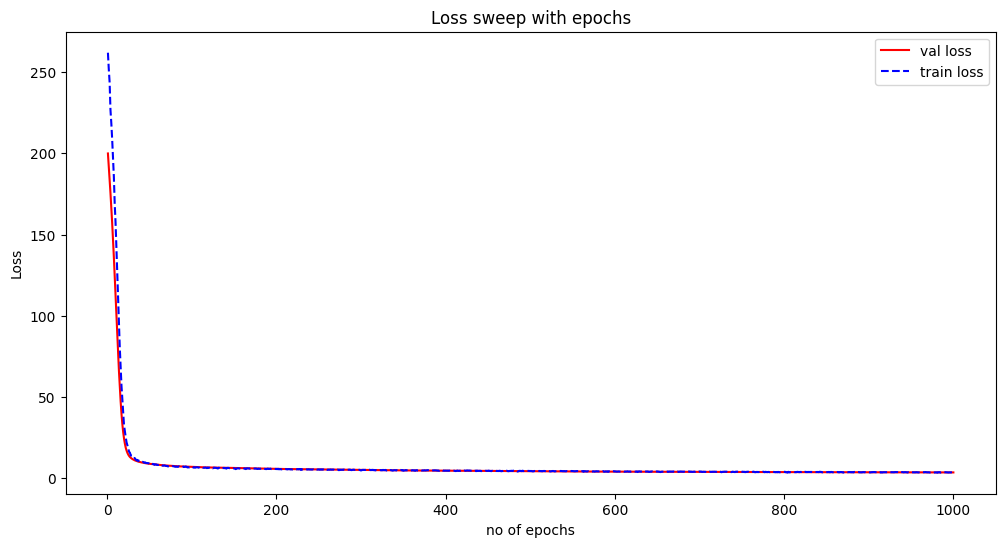

In [18]:
# train_accuracy = model.train_accuracy
val_loss = model.val_loss
train_loss = model.train_loss
v_epochs = range(1, len(val_loss)+1)

plt.figure(figsize=(12, 6))
plt.plot(v_epochs, val_loss, color='red', label='val loss')
plt.plot(v_epochs, train_loss, color='blue', linestyle='--', label='train loss')
plt.xlabel('no of epochs')
plt.ylabel('Loss')
plt.title('Loss sweep with epochs')
plt.legend()

In [58]:
y_pred = model.predict(X_val)
print(mean_squared_error(y_pred, y_val))

7.305567998282335


In [8]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "epochs": {"values": [2000, 1500, 1000, 750, 500]},
        "lr": {"values": [0.000001, 0.000005, 0.00001, 0.00005, 0.0001]},
        "activation_func": {"values": ['sigmoid', 'relu', 'tanh']},
        "optimizer": {"values": ['batch', 'sgd', 'mini-batch']},
        "hidden_layer_neurons": {"values": [5, 8, 10, 12]},
        "hidden_layer": {"values": [1, 2, 3, 4]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="3-mlp-regression")

def tuning():
    run = wandb.init()

    lr = wandb.config.lr
    epochs = wandb.config.epochs
    activation_func = wandb.config.activation_func
    optimizer = wandb.config.optimizer
    hidden_layer_neurons = wandb.config.hidden_layer_neurons
    hidden_layers = wandb.config.hidden_layer

    # for epoch in np.arange(epochs-10, epochs):
    model = MLP_regression(X_train, y_train, X_val=X_val, y_val=y_val, learning_rate=lr, max_epochs=epochs, activation_func=activation_func, optimizer=optimizer, hidden_layer_neurons=hidden_layer_neurons, hidden_layers=hidden_layers)
    model.fit()

    # accuracies, losses, v_epochs = regression_model.get_metric_for_each_epoch()
    losses = model.val_loss
    v_epochs = range(1, epochs+1)
    for loss, epoch_count in zip(losses, v_epochs):
        wandb.log({"loss": loss})


wandb.agent(sweep_id, function=tuning, count=50)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 8gb62c2u
Sweep URL: https://wandb.ai/anushka-agrawal/3-mlp-regression/sweeps/8gb62c2u


wandb: Agent Starting Run: 4m8m0z2f with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 2000
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anushka-agrawal. Use `wandb login --relogin` to force relogin


loss,▇██████▇▅▃▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.99733


wandb: Agent Starting Run: s9vwafk8 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 5e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,22.90507


wandb: Agent Starting Run: y8uk9r2j with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 1e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
loss,49.26989


wandb: Agent Starting Run: tu9ljooc with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.07624


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 35bg9hwm with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▁▂▂▁▂▁▂▁▂▂
loss,4.20387


wandb: Agent Starting Run: 6yboisv9 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.1384


wandb: Agent Starting Run: a8ofc9el with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▇▆▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,14.60735


wandb: Agent Starting Run: aw2ym68d with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 750
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,7.20864


wandb: Agent Starting Run: cczw6vju with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 5e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,16.11366


wandb: Agent Starting Run: 2hmsx5n8 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 1e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.99587


wandb: Agent Starting Run: voy28ld9 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 750
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


C:\Users\hp\AppData\Local\Temp\ipykernel_10940\4071508187.py:80: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)


loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,223.25705


wandb: Agent Starting Run: lqzny3sd with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.38564


wandb: Agent Starting Run: oy44pmd7 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 1e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
loss,146.58091


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 86eaiii5 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 750
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.63574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kn0gvufx with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,5.42896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8a30cbtp with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 5e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.01713


wandb: Agent Starting Run: 23m7drwy with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,27.06805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s0cbdst6 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,7.46649


wandb: Agent Starting Run: 7m6igr2o with config:
wandb: 	activation_func: relu
wandb: 	epochs: 750
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 0.0001
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
loss,3.60787


wandb: Agent Starting Run: ws8v6phz with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 5e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.76059


wandb: Agent Starting Run: zaceihil with config:
wandb: 	activation_func: relu
wandb: 	epochs: 500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,27.09844


wandb: Agent Starting Run: uqih9cw4 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 750
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,26.85888


wandb: Agent Starting Run: nr1vihht with config:
wandb: 	activation_func: relu
wandb: 	epochs: 500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.75939


wandb: Agent Starting Run: jept5rrp with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.83764


wandb: Agent Starting Run: gr5g046t with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,27.09747


wandb: Agent Starting Run: 6vimla5k with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.73317


wandb: Agent Starting Run: 7rhw6ucn with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.18728


wandb: Agent Starting Run: lwe36s69 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 750
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.84863


wandb: Agent Starting Run: jceg6t21 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 750
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 1e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
loss,131.41254


wandb: Agent Starting Run: jw0czcmj with config:
wandb: 	activation_func: relu
wandb: 	epochs: 500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.78991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wthak130 with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 1e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2.94536


wandb: Agent Starting Run: 5olerl8m with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 2000
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█████████████████████▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.67049


wandb: Agent Starting Run: zvc1cvsl with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,26.43247


wandb: Agent Starting Run: d58io2bm with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 750
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,24.57128


wandb: Agent Starting Run: zq0tnvr4 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 750
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 5e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.73704


wandb: Agent Starting Run: jwtsq0xn with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.33229


wandb: Agent Starting Run: 3k851qln with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.67383


wandb: Agent Starting Run: tctpcn67 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 2000
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-06
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,8.52281


wandb: Agent Starting Run: bfuwdyyt with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 500
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 12
wandb: 	lr: 5e-05
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.64922


wandb: Agent Starting Run: 8twy06fd with config:
wandb: 	activation_func: relu
wandb: 	epochs: 2000
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 1e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.50778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: evcj7j6a with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 5e-05
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,▇██████▇▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.6776


wandb: Agent Starting Run: 7fjcfjal with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 1e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,27.03324


wandb: Agent Starting Run: 38re3w6b with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 1000
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 5e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▇▆▆▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,27.09677


wandb: Agent Starting Run: 7ex99wps with config:
wandb: 	activation_func: relu
wandb: 	epochs: 500
wandb: 	hidden_layer: 4
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▃▂▂▂▂▁▁▁▁▁▁▂▁▁▂▃▁▂▂▃▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂
loss,4.27847


wandb: Agent Starting Run: s1qwnjbe with config:
wandb: 	activation_func: relu
wandb: 	epochs: 750
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 5e-05
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.71026


wandb: Agent Starting Run: z7kw9qcr with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 8
wandb: 	lr: 5e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.89989


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7vsz6sd9 with config:
wandb: 	activation_func: tanh
wandb: 	epochs: 750
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,3.96524


wandb: Agent Starting Run: pg8t9vqa with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1000
wandb: 	hidden_layer: 3
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 1e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,████▇▇▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,6.00966


wandb: Agent Starting Run: cy2uy2q1 with config:
wandb: 	activation_func: sigmoid
wandb: 	epochs: 1500
wandb: 	hidden_layer: 2
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 1e-06
wandb: 	optimizer: mini-batch
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,██▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,22.35641


wandb: Agent Starting Run: a9c7fq6z with config:
wandb: 	activation_func: relu
wandb: 	epochs: 1500
wandb: 	hidden_layer: 1
wandb: 	hidden_layer_neurons: 5
wandb: 	lr: 1e-06
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loss,█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,8.20569


The link to my wandb report for logging loss and accuracy is:
https://api.wandb.ai/links/anushka-agrawal/zy24lcmk

In [15]:
activation_funcs = ['sigmoid', 'relu', 'tanh']
optimizers = ['batch', 'sgd', 'mini-batch']

activation_functions = []
optimizers_ = []
mse_losses = []
rmse_losses = []
r2_losses = []

for activation_func in activation_funcs:
    for optimizer in optimizers:
        model = MLP_regression(X_train, y_train, X_val, y_val, activation_func=activation_func, optimizer=optimizer, learning_rate=0.0001, max_epochs=1000, hidden_layers=1, hidden_layer_neurons=10)
        model.fit()

        y_pred = model.predict(X_val)
        y_pred = np.nan_to_num(y_pred, nan=0.0)
        mse_loss = mean_squared_error(y_pred, y_val)
        r2_loss = r2_score(y_pred, y_val)
        rmse_loss = math.sqrt(mse_loss)

        activation_functions.append(activation_func)
        optimizers_.append(optimizer)
        mse_losses.append(mse_loss)
        rmse_losses.append(rmse_loss)
        r2_losses.append(r2_loss)

C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:86: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:69: RuntimeWarning: overflow encountered in square
  return (1/(2*self.batch_size)) * np.sum((y-y_pred)**2)


In [16]:
dataframe = {
    "Activation functions": activation_functions,
    "Optimizers": optimizers_,
    "MSE Loss": mse_losses,
    "RMSE Loss": rmse_losses,
    "R2 Loss": r2_losses
}

df = pd.DataFrame(dataframe)
print(df)

  Activation functions  Optimizers    MSE Loss  RMSE Loss   R2 Loss
0              sigmoid       batch    6.167094   2.483363  0.907996
1              sigmoid         sgd    6.242629   2.498525  0.907129
2              sigmoid  mini-batch    6.228263   2.495649  0.907404
3                 relu       batch  540.488421  23.248407  0.000000
4                 relu         sgd   13.272815   3.643187  0.843664
5                 relu  mini-batch   13.192778   3.632186  0.843942
6                 tanh       batch   11.518085   3.393830  0.843528
7                 tanh         sgd   13.114746   3.621429  0.807330
8                 tanh  mini-batch   13.146794   3.625851  0.839623


In [19]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
epochs = [250, 500, 1000, 1500, 2000]
hidden_layer_neurons = [5, 8, 10, 12]
hidden_layers = [1, 2, 3, 4]

learning_rates_ = []
epochs_ = []
hidden_layer_neurons_ = []
hidden_layers_ = []
mse_losses = []
rmse_losses = []
r2_losses = []

for lr in learning_rates:
    for epoch in epochs:
        for hidden_layer_neuron in hidden_layer_neurons:
            for hidden_layer in hidden_layers:
                model = MLP_regression(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='batch', learning_rate=lr, max_epochs=epoch, hidden_layers=hidden_layer, hidden_layer_neurons=hidden_layer_neuron)
                model.fit()
                y_pred = model.predict(X_val)
                y_pred = np.nan_to_num(y_pred, nan=0.0)

                mse_loss = mean_squared_error(y_pred, y_val)
                r2_loss = r2_score(y_pred, y_val)
                rmse_loss = math.sqrt(mse_loss)

                learning_rates_.append(lr)
                epochs_.append(epoch)
                hidden_layer_neurons_.append(hidden_layer_neuron)
                hidden_layers_.append(hidden_layer)                
                mse_losses.append(mse_loss)
                rmse_losses.append(rmse_loss)
                r2_losses.append(r2_loss)

C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:86: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:69: RuntimeWarning: overflow encountered in square
  return (1/(2*self.batch_size)) * np.sum((y-y_pred)**2)
C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:86: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:86: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidden_layers_z[-i-1]) * np.dot(delta_t, self.weights[-i].T)
C:\Users\hp\AppData\Local\Temp\ipykernel_15648\1483526946.py:86: RuntimeWarning: invalid value encountered in multiply
  delta_t_ = self.__activation_prime(self.hidd

In [22]:
dataframe = {
    "learning rate": learning_rates_,
    "epochs": epochs_,
    "hidden layer neurons": hidden_layer_neurons_,
    "hidden layers": hidden_layers_,
    "MSE Loss": mse_losses,
    "RMSE Loss": rmse_losses,
    "R2 Loss": r2_losses
}

df = pd.DataFrame(dataframe)
# print(df)
df = df.sort_values(by='MSE Loss')
df

,learning rate,epochs,hidden layer neurons,hidden layers,MSE Loss,RMSE Loss,R2 Loss
404,0.00005,250,8,1,6.554635,2.560202,0.909727
412,0.00005,250,12,1,6.688173,2.586150,0.906558
428,0.00005,500,12,1,7.009360,2.647520,0.907583
460,0.00005,1500,12,1,7.337848,2.708846,0.903971
420,0.00005,500,8,1,7.425200,2.724922,0.898829
...,...,...,...,...,...,...,...
153,0.00500,2000,10,2,540.488421,23.248407,0.000000
152,0.00500,2000,10,1,540.488421,23.248407,0.000000
151,0.00500,2000,8,4,540.488421,23.248407,0.000000
478,0.00005,2000,12,3,540.488421,23.248407,0.000000


In [19]:
model = MLP_regression(X_train, y_train, X_val, y_val, activation_func='relu', optimizer='batch', learning_rate=0.00005, max_epochs=250, hidden_layers=1, hidden_layer_neurons=8)
model.fit()

y_pred = model.predict(X_test)
y_pred = np.nan_to_num(y_pred, nan=0.0)
mse_loss = mean_squared_error(y_pred, y_test)
r2_loss = r2_score(y_pred, y_test)
rmse_loss = math.sqrt(mse_loss)

print("MSE Loss: ", mse_loss)
print("RMSE Loss: ", rmse_loss)
print("R2 Loss: ", r2_loss)


MSE Loss:  7.792225807624188
RMSE Loss:  2.791455858082694
R2 Loss:  0.8269901241321885
